In [1]:
import numpy as np
import os
import datetime 

# Tao
from pytao import Tao

#BO
from bayes_opt import BayesianOptimization

# openPMD-beamphysics
from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import twiss_match, matched_particles
from pmd_beamphysics.statistics import slice_statistics, twiss_dispersion_calc
from pmd_beamphysics.plot import slice_plot, marginal_plot, density_and_slice_plot
from h5py import File

# FEL parametrization
from fel_mx_model import resonantLambda, rhoFEL, gainLength1D, getLambdaMX, gainLength,\
                         Pbeam, Psat, Pz, shot_noise

# LCLS and physics params
from constants import m_e, e, c, hc, markers, z, K_u, lambda_u, I_A

# nicer plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8,4)
plt.rcParams.update({'font.size': 14})

# useful for debugging
%load_ext autoreload
%autoreload 2

# Run Tao and get beam data

In [2]:
init = '-init ./tao.init -noplot'
# Make tao instance
tao=Tao(init)   

In [3]:
# Turn on beam, set number of particles, and insert collimator in BC1

In [25]:
%%tao
snparticle 1500
beamon


-------------------------
Tao> snparticle 1500


RuntimeError: Command: snparticle 1500 causes error: ERROR detected: [ERROR | 2021-AUG-24 18:12:51] calc_emittances_and_twiss_from_sigma_matrix:
    CANNOT NORMALIZE EIGENVECTORS.
[WARNING] tao_beam_track:
    Beam parameters not computed at: K23_7D  (596)
    [This will happen with round beams. Ignore this problem if the beam parameters at problem locations are not needed.]
    The singular sigma matrix is:
        1.4073176E-09  4.7032403E-11 -3.2466779E-11 -1.2750128E-12  9.4492493E-11 -3.2266159E-09
        4.7032403E-11  3.2972547E-12  8.0531790E-14 -9.4914828E-14  8.9211155E-12 -2.9894079E-10
       -3.2466779E-11  8.0531790E-14  5.5908159E-10 -4.4037761E-13  5.2233493E-12 -1.5511270E-10
       -1.2750128E-12 -9.4914828E-14 -4.4037761E-13  4.2668450E-12  3.0874283E-13 -8.6165618E-12
        9.4492493E-11  8.9211155E-12  5.2233493E-12  3.0874283E-13  3.6117304E-09 -1.1905744E-07
       -3.2266159E-09 -2.9894079E-10 -1.5511270E-10 -8.6165618E-12 -1.1905744E-07  3.9255413E-06
    Will not print any more singular sigma matrices for this track...
Total number of lost particles by the end of universe  1:   561.

In [4]:
def setLinac(l1_phase, l1x_phase, l2_phase):
    # start with L1, L1X and L2 phases
    tao.cmd(f'set ele O_L1 phase_deg={l1_phase}')
    tao.cmd(f'set ele K21_2 phase_deg={l1x_phase}')
    tao.cmd(f'set ele O_L2 phase_deg={l2_phase}')

In [6]:
# updates: only use collimator in BC1 (talked to William)
#-21.5, -160.0, -33.5
#set ele CE11 x2_limit = 0.000002; set ele CE11 x1_limit = 0.1;

(-21.5, -160.0, -33.5)

In [20]:
%%tao
set ele CE11 x2_limit = 0.0035; set ele CE11 x1_limit = 0.0015;

-------------------------
Tao> set ele CE11 x2_limit = 0.0035; set ele CE11 x1_limit = 0.0015;


RuntimeError: Command: set ele CE11 x2_limit = 0.0035; set ele CE11 x1_limit = 0.0015; causes error: ERROR detected: [ERROR | 2021-AUG-24 18:11:13] calc_emittances_and_twiss_from_sigma_matrix:
    CANNOT NORMALIZE EIGENVECTORS.
[WARNING] tao_beam_track:
    Beam parameters not computed at: K22_2A#3  (421)
    [This will happen with round beams. Ignore this problem if the beam parameters at problem locations are not needed.]
    The singular sigma matrix is:
        5.4754443E-09 -2.9038346E-10  7.1957915E-13 -3.0321821E-12 -8.1416669E-11  3.0742077E-09
       -2.9038346E-10  1.8679892E-11  1.0740474E-12  1.0278411E-13  1.2283936E-11 -4.8526953E-10
        7.1957915E-13  1.0740474E-12  1.2993464E-09  3.7184209E-11 -3.3990601E-11  1.3709834E-09
       -3.0321821E-12  1.0278411E-13  3.7184209E-11  1.4251534E-11  2.1998057E-12 -8.6358955E-11
       -8.1416669E-11  1.2283936E-11 -3.3990601E-11  2.1998057E-12  3.4636833E-09 -1.3615497E-07
        3.0742077E-09 -4.8526953E-10  1.3709834E-09 -8.6358955E-11 -1.3615497E-07  5.3574149E-06
    Will not print any more singular sigma matrices for this track...
Total number of lost particles by the end of universe  1:  2246.

Tao: set ele CE11 x1_limit = 0.0015
2246 particle(s) lost at element 262: CE11  Total lost: 2246  of 6000
[ERROR | 2021-AUG-24 18:11:28] calc_emittances_and_twiss_from_sigma_matrix:
    CANNOT NORMALIZE EIGENVECTORS.
[WARNING] tao_beam_track:
    Beam parameters not computed at: K22_2A#3  (421)
    [This will happen with round beams. Ignore this problem if the beam parameters at problem locations are not needed.]
    The singular sigma matrix is:
        5.4754829E-09 -2.9038668E-10  7.2558118E-13 -3.0310480E-12 -8.1385010E-11  3.0730682E-09
       -2.9038668E-10  1.8680104E-11  1.0736248E-12  1.0274969E-13  1.2282885E-11 -4.8523098E-10
        7.2558118E-13  1.0736248E-12  1.2993463E-09  3.7184209E-11 -3.3990075E-11  1.3710300E-09
       -3.0310480E-12  1.0274969E-13  3.7184209E-11  1.4251535E-11  2.1997919E-12 -8.6361006E-11
       -8.1385010E-11  1.2282885E-11 -3.3990075E-11  2.1997919E-12  3.4636854E-09 -1.3615504E-07
        3.0730682E-09 -4.8523098E-10  1.3710300E-09 -8.6361006E-11 -1.3615504E-07  5.3574168E-06
    Will not print any more singular sigma matrices for this track...
Total number of lost particles by the end of universe  1:  2246.

In [12]:
setLinac( -21.5, -160.0, -33.5) #-23.37  , -144.0  , -36.71)

RuntimeError: Command: set ele O_L2 phase_deg=-36.71 causes error: ERROR detected: [ERROR | 2021-AUG-19 08:53:05] EIGENSYS:
    no eigensystem found ; skipping
[ERROR | 2021-AUG-19 08:53:05] tao_beam_track:
    Singular sigma matrix is:
        1.4032555E-09 -2.3173460E-11  1.0010795E-10  2.0008937E-12 -8.5005426E-12 -1.0792039E-09
       -2.3173460E-11  1.1933877E-12 -1.4922259E-12 -5.8647549E-14  5.9378802E-13 -1.9275889E-11
        1.0010795E-10 -1.4922259E-12  2.9821942E-09  6.2109138E-11 -2.2634831E-11  1.9709829E-09
        2.0008937E-12 -5.8647549E-14  6.2109138E-11  1.7592658E-12 -1.0735009E-13  1.3770655E-11
       -8.5005426E-12  5.9378802E-13 -2.2634831E-11 -1.0735009E-13  3.7292951E-11 -4.3962870E-09
       -1.0792039E-09 -1.9275889E-11  1.9709829E-09  1.3770655E-11 -4.3962870E-09  9.6741912E-07
    Will not print any more singular sigma matrices for this track...
Total number of lost particles by the end of universe  1:   260.

In [21]:
# write beam at each marker in undulator
#timestamp = '07-07_10-30'

timestamp = 'test'
#timestamp = timestamp = (datetime.datetime.now()).strftime("%m-%d_%H-%M")

In [26]:
# need to log settings for bmad somewhere here?

for i,marker in enumerate(markers):
    tao.cmd(f'write beam -at {marker} ./beam_undulator_data/lcls_beam_{i}_{marker}_{timestamp}.h5')

# Import data and slice beam bunches 

In [38]:
# create ParticleGroup from bmad h5 particle data
directory = './beam_undulator_data/'

# Beam data along undulator
P_data= {}

for i,marker in enumerate(markers):
    filename = f'lcls_beam_{i}_{marker}_{timestamp}.h5'
    P_data[f'{marker}'] = ParticleGroup(directory+filename)   
        
# collimation loses some particles, take only alive particles here
for beam in P_data:
    P_data[beam] = P_data[beam].where(P_data[beam].status==1) # status 1 is alive
    n_part_alive = P_data[beam].n_alive


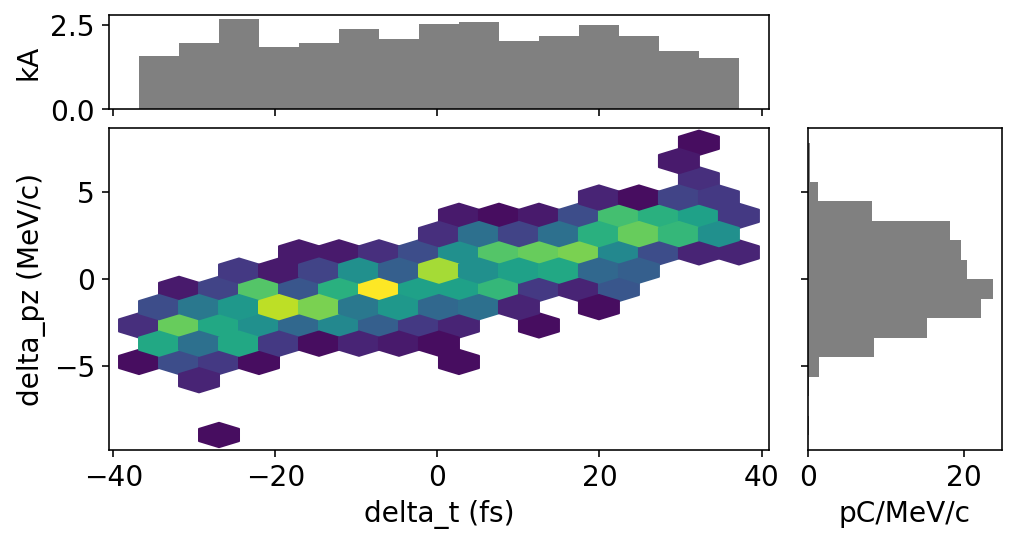

In [39]:
P_data['VVHXU19'].plot('delta_t', 'delta_pz')

In [137]:
slices = {}
# update after talking to Chris: take small number of slices and get avg of needed stats (~100 part in each slice)
n_slice = int(n_part_alive/100)

## getting sliced stats for beam at each marker (along z)
for i,marker in enumerate(markers):
    P = P_data[f'{marker}'] 
    slices[marker] = slice_statistics(P, \
                            keys=["sigma_pz","mean_pz","average_current","norm_emit_x","norm_emit_y",\
                                  "mean_px", "mean_x", "mean_py", "mean_y", "sigma_x", "sigma_y", "mean_t", "mean_t"], \
                             n_slice = n_slice, slice_key='t')

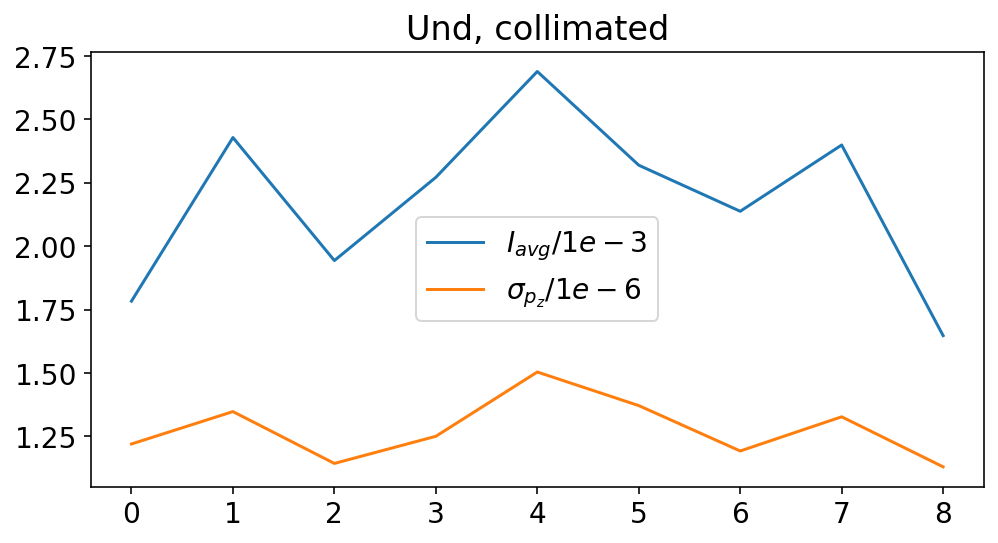

In [138]:
#fig, ax = plt.subplots(3, sharex=True, figsize=(10,13))
sl = slices["VVHXU19"]

#plt.plot(sl['norm_emit_x']*10**(9), label=r"$\epsilon_x$")
#plt.plot(sl['norm_emit_y']*10**(9), label=r"$\epsilon_y$")
plt.plot(sl['average_current']*10**(-3), label=r"$I_{avg}/1e-3$")
plt.plot(sl['sigma_pz']*10**(-6), label=r"$\sigma_{p_z}/1e-6$")
plt.title("Und, collimated")

plt.legend()

# ============ smoothing MX with interpolation ===================
stats needed per slice:
* mean_pz
* sigma_pz
* average_current
* norm_emit_x
* norm_emit_y
* sigma_x
* sigma_y

In [139]:
# get arrays of the stats for all slices:
keys = ["mean_pz", "sigma_pz", "average_current", "norm_emit_x", "norm_emit_y", "sigma_x", "sigma_y", "mean_t"]

for marker in markers:
    for key in keys:
        stats = slices[marker][key]

In [140]:
from scipy.interpolate import CubicSpline as cubicspline

test = cubicspline(slices["VVHXU25"]["mean_t"], slices["VVHXU25"]["average_current"])

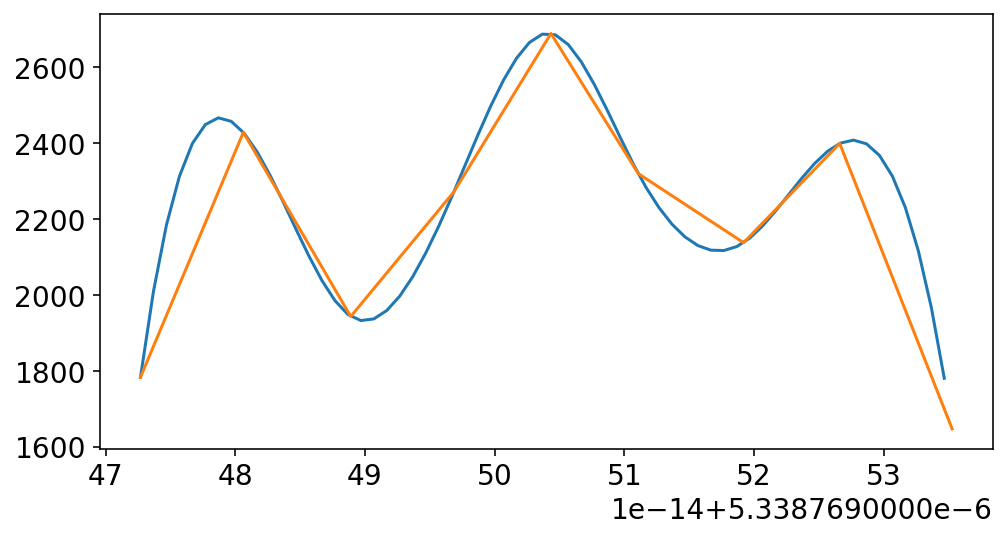

In [141]:
xs = np.arange(slices["VVHXU25"]["mean_t"].min(), slices["VVHXU25"]["mean_t"].max(), 1e-15)
plt.plot(xs, test(xs))
plt.plot(slices["VVHXU25"]["mean_t"], slices["VVHXU25"]["average_current"])

# =======================================================

## Find 3D gain length

In [37]:
# instant growth rate (Lg) at each marker for each slice
lg_slice = []

for i,marker in enumerate(markers):
    
    # particle group/slice
    sl = slices[marker]
    P = P_data[marker] 

    # emittances
    norm_emit_x = sl["norm_emit_x"]
    norm_emit_y = sl["norm_emit_y"]
    
    # average current
    current_beam = sl["average_current"]

    # energy spread
    sig_pz = sl["sigma_pz"]/19 # adjusted just to test, take real one here after fixing horns!!!!!!!!!!!!!
    #sig_pz = [0.5*1e7 if x>0.5*1e7 else x for x in sl["sigma_pz"]] # adjusted just to test, take real one here after fixing horns!!!!!!!!!!!!!
    mean_pz = sl["mean_pz"]

    # gamma relativistic
    gamma_beam = sl["mean_pz"]/P.mass 
    
    # normalization factor for each slice ---> is this correct or is it beta*gamma?????????????????????
    norm_fac_mult = gamma_beam 

    # unnormalized emittances
    un_emit_x = norm_emit_x/norm_fac_mult # [m]
    un_emit_y = norm_emit_y/norm_fac_mult
    
    # beam sizes
    sig_x = sl["sigma_x"]
    sig_y = sl["sigma_y"]

    # geom size
    sizes = np.sqrt(sig_x*sig_y) #check for MX assumptions: assymmetric beam size?????????????????????
    
    # geom emittance (not normalized)
    emittance = np.sqrt(un_emit_x * un_emit_y)

    # radiation wavelength
    lambda_rad = resonantLambda(gamma_beam, K_u, lambda_u)
    
    # FEL parameter
    rho = rhoFEL(current_beam, sizes, gamma_beam)
    
    # get instant. Lg
    Lg1D = gainLength1D(rho, lambda_u)
    
    # Ming Xie
    LambdaMX = getLambdaMX(Lg1D, sizes, lambda_rad, emittance, lambda_u, sig_pz, mean_pz)
    Lg = gainLength(Lg1D, LambdaMX)
    
    # append to list
    lg_slice.append(Lg)

### Find z location reached 18Lg

In [38]:
# Get z distance between markers (dZ)
dZ = [0]*len(z)

for i,loc in enumerate(z):
    dz = loc-z[i-1]
    
    if dz == 0 or i ==0:
        dz = 0 
    dZ[i] = dz

In [39]:
lg_cumul_slice = [] # gain lengths so far for each slice
zsat = [] # z at saturation
zsat_idx = [] # index of z list at saturation

for j in range(n_slice):
    fracLgcum = 0
    satQ = False
    list_lg_cum = [] # for each slice get Lg along z
    
    for i, instLg in enumerate(lg_slice):
        # at this location in und, get number of gain lengths so far
        fracLg = dZ[i]/instLg[j] # dist since last marker in fractions of Lg at this marker
        Lgcum = fracLg + fracLgcum # increment to find 18Lg marker location
        fracLgcum = Lgcum
        list_lg_cum.append(Lgcum)
        
        if fracLgcum > 18 and satQ == False:
            satQ = True
            #print(f"saturated at z = {z[i]}, marker = {markers[i]}")
            zsat.append(z[i])
            zsat_idx.append(i)
            
    lg_cumul_slice.append(list_lg_cum)

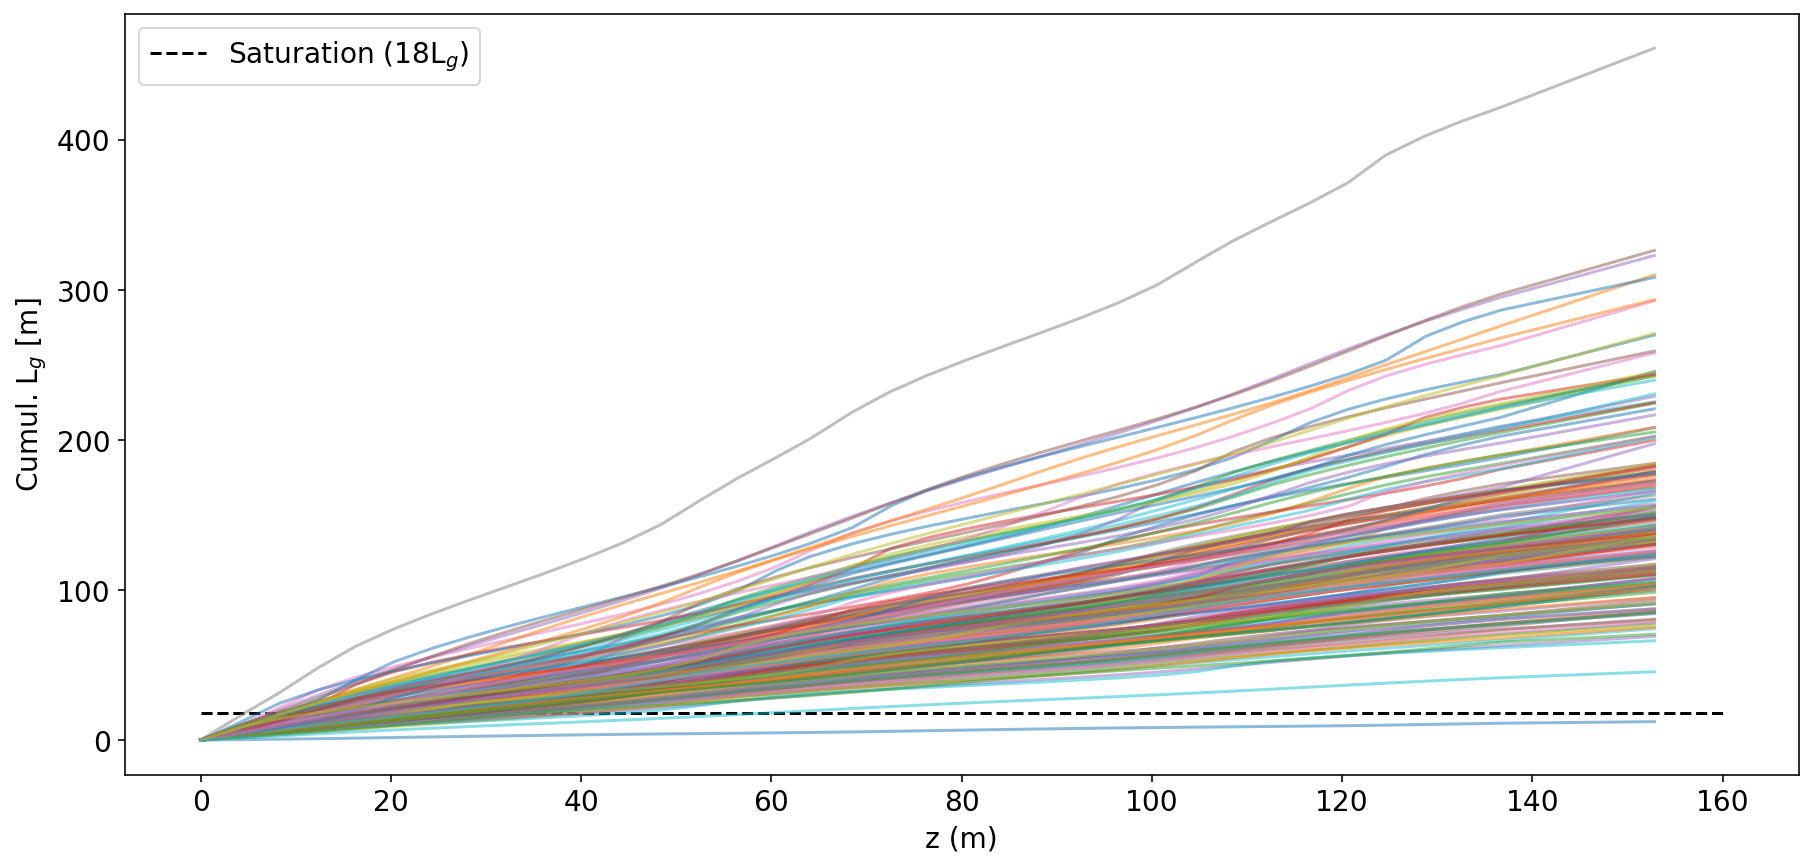

In [40]:
plt.figure(figsize=(15,7))

for i in range(n_slice):
    # plot cumulative Lg for each slice along undulator
    plt.plot(z, lg_cumul_slice[i], alpha=0.5)

# saturation point
plt.hlines(18, 0, 160, linestyle="--", color="black", label="Saturation (18L$_g$)")

plt.legend()
plt.ylabel(r"Cumul. L$_g$ [m]");
plt.xlabel("z (m)");

### Find saturation power

In [42]:
# get avg Lg for each slice from saturation point
lg_avg = []

#for i in range(n_slice): # SOME DON'T SATURATE HERE
for i in range (len(zsat)):
    lg_avg.append(zsat[i]/18) # wait is this correct?
    
p_shotnoise_list, rho_list, psat_list, mean_pz_list, current_list, sizes_list, lambda_rad_list = \
[], [], [], [], [], [], []

# loop over slices at the point where each saturates
for i in range(n_slice):
    # z along und where saturation happens
    sl = slices[markers[zsat_idx[i]]]
    P = P_data[markers[zsat_idx[i]]]

    # emittances
    norm_emit_x = sl["norm_emit_x"][i]
    norm_emit_y = sl["norm_emit_y"][i]
    
    # average current
    #current_beam = sl["average_current"][i]
    current_beam = 8*1e3 if sl["average_current"][i]>8*1e3 else sl["average_current"][i]

    current_list.append(current_beam)

    # energy spread
    sig_pz = sl["sigma_pz"][i]/19 # need to adjust later !!!!!!!!!!!!!!!!!!!!!!
    #sig_pz = 0.5*1e7 if sl["sigma_pz"][i]>0.5*1e7 else sl["sigma_pz"][i]
    mean_pz = sl["mean_pz"][i]
    mean_pz_list.append(mean_pz)
    
    # gamma relativistic
    gamma_beam = sl["mean_pz"][i]/P.mass 
    
    # unnormalized emittances
    un_emit_x = norm_emit_x/norm_fac_mult[i] # [m]
    un_emit_y = norm_emit_y/norm_fac_mult[i]
    emittance = np.sqrt(un_emit_x * un_emit_y)
    
    sig_y = sl["sigma_y"][i]
    sig_x = sl["sigma_x"][i]

    
    sizes = np.sqrt(sig_x*sig_y)
    sizes_list.append(sizes)
    
    # get inst Lg
    lambda_rad = resonantLambda(gamma_beam, K_u, lambda_u)
    lambda_rad_list.append(lambda_rad)
    
    rho = rhoFEL(current_beam, sizes, gamma_beam)
    rho_list.append(rho)
    Lg1D = gainLength1D(rho, lambda_u)
    
    p_shotnoise_list.append(shot_noise(rho, lambda_rad, current_beam, gamma_beam))
    pbeam = Pbeam(gamma_beam, current_beam)
    
    # not sure if correct to us 3DLg in MX factor?
    LambdaMX = getLambdaMX(lg_avg[i], sizes, lambda_rad, emittance, lambda_u, sig_pz, mean_pz)
    Lg = lg_avg[i]
    
    psat_list.append(Psat(LambdaMX, rho, pbeam)) # in GW
    print(Psat(LambdaMX, rho, pbeam), current_beam/1e3, Pz(shot_noise(rho, lambda_rad, current_beam, gamma_beam), 18))

0.16826014377099774 0.07133521181540427 1.6780012124516692
5.943114958858855 0.8401746835030568 14.08253852122355
10.637186585032056 1.2994539752905239 11.479356993380286
30.877033360779933 2.672460783672485 26.09636813296109
98.75905549801512 7.340846390279649 31.641360958575465
31.836525909780967 3.141759729828898 16.244661456849887
55.11978890268715 4.348595962682419 31.651039304793624
36.19057220616644 3.4427610542305036 16.494768636115868
115.33793182247142 7.486835611340831 33.39307257641956
119.7840839514886 8.0 49.28125600433189
22.839890026879704 2.481459587646684 12.407722213583337
55.96672240914329 4.008214830149501 49.388294707632866
40.01059800960044 3.722960164474662 17.122458576510255
116.38077976915565 8.0 35.91638928500229
42.20834938392857 3.6814222524524522 21.029409284736428
80.92052310067464 8.0 16.605042712904268
8.073632352649955 1.109124100196465 8.135700234263606
64.04413863991914 4.543043470980361 34.81068506706753
112.92468646897613 8.0 32.156667523527766
47.

IndexError: list index out of range

In [43]:
def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

def find_bin(value, bins):
    """ bins is a list of tuples, like [(0,20), (20, 40), (40, 60)],
        binning returns the smallest index i of bins so that
        bin[i][0] <= value < bin[i][1]
    """
    
    for i in range(0, len(bins)):
        if bins[i][0] <= value < bins[i][1]:
            return i
    return -1

In [53]:
min_e = min(mean_pz_list)
max_e = max(mean_pz_list)
(max_e - min_e)/np.mean(mean_pz_list)*100
min_e, max_e, (max_e-min_e), int((max_e-min_e)/bin_size)

(7972555380.1666, 7992511989.9732895, 19956609.806689262, 39)

In [45]:
bin_size = 500000
bins = create_bins(lower_bound= int(min_e),
                       width=bin_size,
                       quantity= int((max_e-min_e)/bin_size))

In [46]:
import scipy.constants as constants

binned_psat = [0]*len(bins)
binned_e_phot = [0]*len(bins)
binned_num_phot = [0]*len(bins)
en_idx = []

for i in range(n_slice):
    # find e- energy bin index
    bin_index = find_bin(mean_pz_list[i], bins)
    en_idx.append(bin_index)

    # increment Psat val at that bin index
    binned_psat[bin_index] = binned_psat[bin_index] + psat_list[i]
    
#     if slice_energy[bin_index]>80:
#         print(bin_index, current_list[i], psat_list[i], slice_energy[bin_index])

    # photons/sec from power: divide by photon energy [W]/[J]= ph/[s]
    # need photon energy corresponding to each electron energy bin
    
    
    binned_e_phot = constants.h*c/(lambda_rad_list[i]) # [J.s]x[m/s]/m
    binned_num_phot[bin_index] = binned_psat[bin_index]*1e9/120 / binned_e_phot + binned_num_phot[bin_index]
    #binned_num_phot[bin_index] = binned_e_phot/constants.h + binned_num_phot[bin_index]
    

IndexError: list index out of range

(0.0, 2000.0)

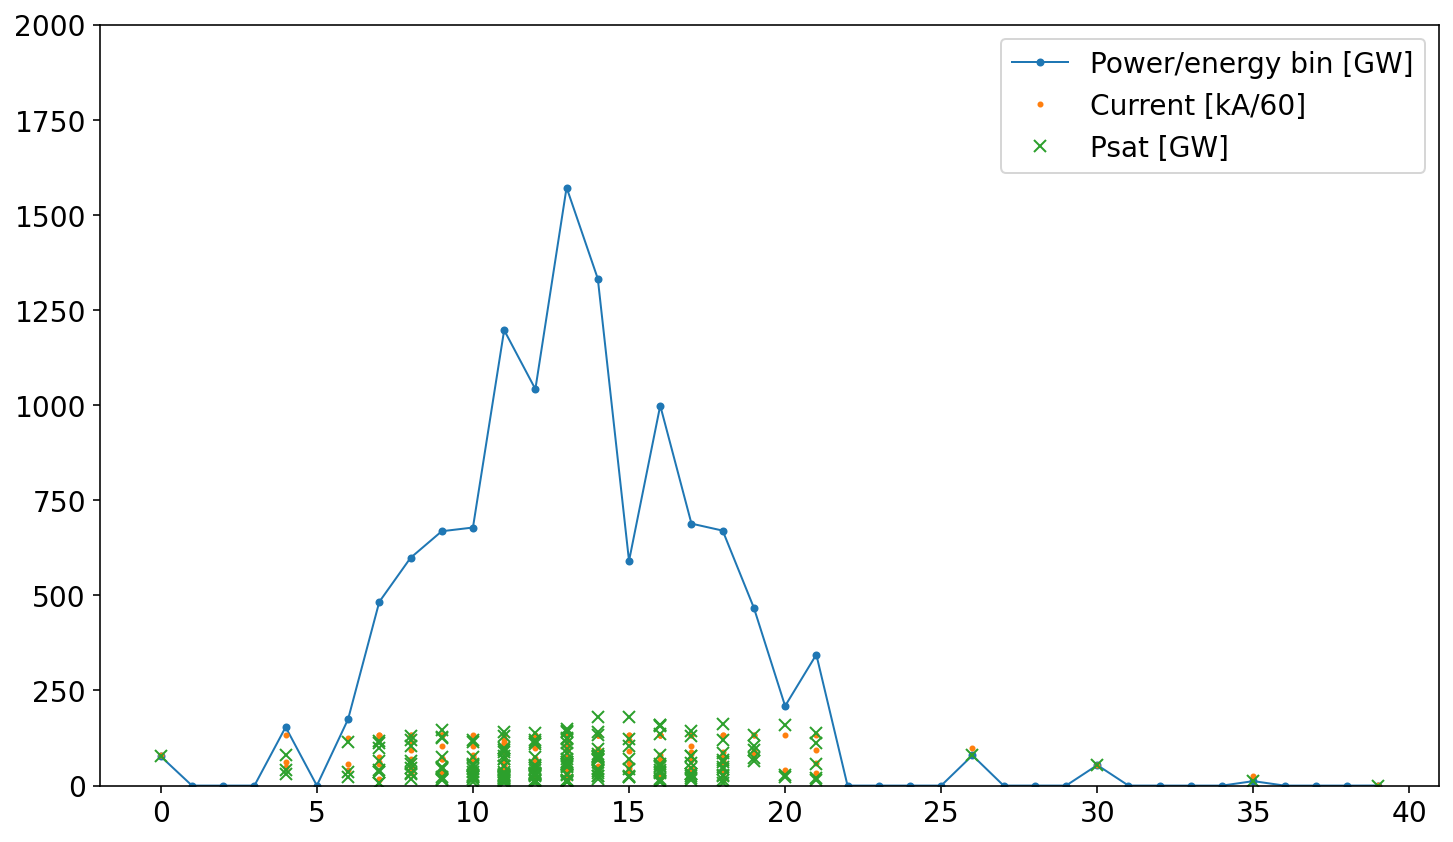

In [47]:
plt.figure(figsize=(12,7))

plt.plot(binned_psat, linewidth=1, marker='.', label="Power/energy bin [GW]")
#plt.ylabel("P/energy bin [GW]")

plt.plot(en_idx, np.array(current_list)/60, linewidth=0, marker='o', markersize=2, label="Current [kA/60]")
plt.plot(en_idx, np.array(psat_list), linewidth=0, marker='x', label="Psat [GW]")

plt.legend()

plt.ylim(0,2000)
#plt.plot(np.array(binned_num_phot)/1, linewidth=0, marker='x', markersize=5)

# max 0.6-1.3 E17 photons/s -> expected 0.15-14 E12 ---->>> 5 orders of magnitude off